# Baseline-Year Modeling (Notebook)

This notebook filters `df_merged.csv` to a single **baseline year** (default: 2000), drops suspected leakage/duplicate columns, and trains **Logistic Regression** and **Random Forest** models.  
It prints test metrics and **5-fold CV ROC-AUC**, and saves:
- `roc_curves_baseline_<year>.png`
- `rf_feature_importance_baseline_<year>.png`
- `rf_feature_importance_baseline_<year>.csv`

**Usage:** Edit the parameters in the last cell and run the notebook top-to-bottom.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

def run(data_path: Path, baseline_year: int = 2000):
    # Load
    df = pd.read_csv(data_path)

    # Filter to baseline year
    base = df[df["Year"] == baseline_year].copy()
    if base.empty:
        raise ValueError(f"No rows found for Year == {baseline_year} in {data_path}")

    # Drop leakage/redundant columns
    drop_cols = [
        "Year", "State", "Area (SqMi)",
        "fossil_share_2019",   # future info
        "fossil_share",        # duplicates fossil_share_2000 for baseline
        "Total Generation (MWh)",            # redundant sum
        "Total Energy Consumption (BTU)"     # redundant sum
    ]

    feature_cols = [c for c in base.columns if c not in drop_cols + ["Y_OUTCOME"]]
    X = base[feature_cols].select_dtypes(include=[np.number]).copy()
    y = base["Y_OUTCOME"].astype(int)

    print(f"Baseline year {baseline_year} subset: X={X.shape}, y={y.shape}")
    print("Class balance:", y.value_counts(normalize=True).round(3).to_dict())

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Models
    log_reg = LogisticRegression(max_iter=2000)
    rf = RandomForestClassifier(n_estimators=300, random_state=42)

    # Fit
    log_reg.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    # Predict & evaluate
    y_proba_log = log_reg.predict_proba(X_test)[:, 1]
    y_proba_rf = rf.predict_proba(X_test)[:, 1]
    y_pred_log = (y_proba_log >= 0.5).astype(int)
    y_pred_rf = (y_proba_rf >= 0.5).astype(int)

    print("\n=== Logistic Regression (Test) ===")
    print(classification_report(y_test, y_pred_log, digits=3))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_log), 4))

    print("\n=== Random Forest (Test) ===")
    print(classification_report(y_test, y_pred_rf, digits=3))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 4))

    # Cross-validation (5-fold) on baseline data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_cv = cross_val_score(log_reg, X, y, cv=cv, scoring="roc_auc")
    rf_cv = cross_val_score(rf, X, y, cv=cv, scoring="roc_auc")

    print("\n=== Cross-Validation ROC-AUC (5-fold) ===")
    print(f"Logistic Regression: mean={log_cv.mean():.3f}, std={log_cv.std():.3f}, folds={np.round(log_cv, 4)}")
    print(f"Random Forest:      mean={rf_cv.mean():.3f}, std={rf_cv.std():.3f}, folds={np.round(rf_cv, 4)}")

    # ROC Curves
    fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

    plt.figure()
    plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc(fpr_log, tpr_log):.3f})")
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc(fpr_rf, tpr_rf):.3f})")
    plt.plot([0, 1], [0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves (Baseline Year {baseline_year} Only)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    out_roc = f"roc_curves_baseline_{baseline_year}.png"
    plt.savefig(out_roc, dpi=150)
    plt.show()
    print(f"Saved: {out_roc}")

    # RF Feature Importances
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top15 = importances.head(15)

    plt.figure()
    top15[::-1].plot(kind="barh")
    plt.xlabel("Importance")
    plt.title(f"Random Forest Feature Importance (Top 15) — Baseline {baseline_year}")
    plt.tight_layout()
    out_imp = f"rf_feature_importance_baseline_{baseline_year}.png"
    plt.savefig(out_imp, dpi=150)
    plt.show()
    print(f"Saved: {out_imp}")

    # Also save the full importances to CSV
    out_csv = f"rf_feature_importance_baseline_{baseline_year}.csv"
    importances.to_csv(out_csv, header=["importance"])
    print(f"Saved: {out_csv}")


Baseline year 2000 subset: X=(50, 11), y=(50,)
Class balance: {0: 0.5, 1: 0.5}

=== Logistic Regression (Test) ===
              precision    recall  f1-score   support

           0      0.667     0.400     0.500         5
           1      0.571     0.800     0.667         5

    accuracy                          0.600        10
   macro avg      0.619     0.600     0.583        10
weighted avg      0.619     0.600     0.583        10

ROC-AUC: 0.44

=== Random Forest (Test) ===
              precision    recall  f1-score   support

           0      0.571     0.800     0.667         5
           1      0.667     0.400     0.500         5

    accuracy                          0.600        10
   macro avg      0.619     0.600     0.583        10
weighted avg      0.619     0.600     0.583        10

ROC-AUC: 0.72

=== Cross-Validation ROC-AUC (5-fold) ===
Logistic Regression: mean=0.568, std=0.224, folds=[0.52 0.32 0.64 0.96 0.4 ]
Random Forest:      mean=0.620, std=0.104, folds=[0.5

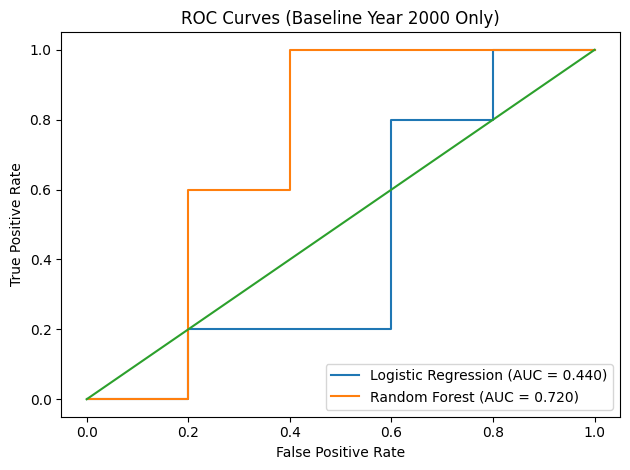

Saved: roc_curves_baseline_2000.png


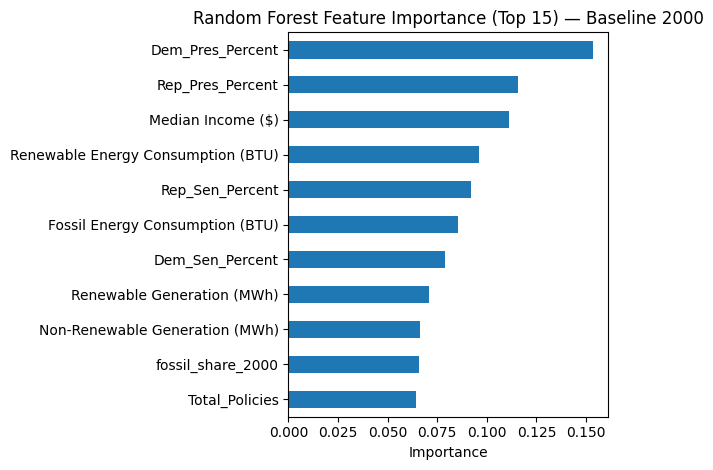

Saved: rf_feature_importance_baseline_2000.png
Saved: rf_feature_importance_baseline_2000.csv


In [ ]:
# Configure and run
DATA_PATH = "/df_merged.csv"  # change if your CSV is elsewhere
BASELINE_YEAR = 2000         # change to any year present in your data

from pathlib import Path
run(Path(DATA_PATH), BASELINE_YEAR)